**Nom** : LOUA  
**Prenoms** : PIVOT REMY   
  
  

**TD - TP 5 Réseau de neurones profonds pour la régression**

Ce TP s’intéresse à la prédiction des prix des appartements à partir d’un ensemble d’attributs. Vous   
serez amené à construire votre premier réseau de neurones profonds. Un compte rendu est demandé en   
fin de séance. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide theses informations : 

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

# Réseau de neurones profonds pour la régression 

In [91]:
from keras.models import Sequential 
from keras.layers import Dense 
from keras.wrappers.scikit_learn import KerasRegressor 
from pandas import read_csv 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split

## Exercice 1 : Lecture et labellisation du jeu de données

### Téléchargez les données et réorganisez les comme suit

In [92]:
df = read_csv("housing_data_for_regression.csv", delim_whitespace=True, header=None)

### On décide de donner des noms aux attributs comme suit

In [93]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = feature_names

Vérifiez en affichant

In [94]:
display(df.head(5).style.format("{0:.2f}").set_caption("Quelques lignes du jeu de données :"))
print('Données manquantes : ',df.isna().sum().sum(), '  Shape  : ', df.shape)

Données manquantes :  0   Shape  :  (506, 14)


Nous avons bien nos données dans la bonne forme avec zéro donnée manquantes.

### Renommez 'MEDV' par 'PRICE' : 


In [95]:
df = df.rename(columns={'MEDV': 'PRICE'}) 

In [96]:
display(df.head(5).style.format("{0:.2f}").set_caption("Quelques lignes du jeu de données :"))
print('Données manquantes : ',df.isna().sum().sum(), '  Shape  : ', df.shape)

Données manquantes :  0   Shape  :  (506, 14)


### Dissociez les attributs à sauveagder dans X des labels à sauvegarder dans y : 

In [97]:
X = df.drop('PRICE', axis = 1) # les attributs
y = df['PRICE'] # les labels

## Exercice 2 : Construction et entrainement du modèle

In [98]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

Le logement de Boston est un jeu de données historique célèbre, nous pouvons donc l'obtenir directement à partir des jeux de [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [99]:
#(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### Préparez le jeu de données d’entrainement et de test comme suit

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20) 

### Normalisation

**Note :** 
 - Toutes les données d'entrée doivent être normalisées, entraînées et testées. 
 - Pour ce faire, nous allons soustraire la moyenne et diviser par l'écart type .
 - Mais les données de test ne doivent en aucun cas être utilisées, même pour la normalisation.
 - La moyenne et l'écart type ne seront donc calculés qu'avec les données du train.

Avant d’entrainer le modèle, il est nécessaire de normaliser les données. Expliquez chacune des 
lignes de code ci-dessous

In [101]:
X_train.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.605117   12.225248   11.189752    0.074257    0.552932    6.291478   
std      8.141616   23.505873    7.013382    0.262514    0.115587    0.714901   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.083827    0.000000    5.130000    0.000000    0.447750    5.878750   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.213500   
75%      3.716457   20.000000   18.100000    0.000000    0.624000    6.632000   
max     73.534100  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean    67.837376    3.812238    9.673267  412.240099   18.408911  354.813985   
std     28.995517    2.159927    8.721052  169.295356    2.170790   93.703644   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     41.800000    2.064700    4.000000  279.000000   17.000000  374.527500   
50%     77.350000    3.190950    5.000000  345.000000   18.900000  391.340000   
75%     94.425000    5.222125   24.000000  666.000000   20.200000  396.157500   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT  
count  404.000000  
mean    12.589975  
std      7.327156  
min      1.730000  
25%      6.720000  
50%     11.235000  
75%     16.945000  
max     37.970000

In [102]:
display(X_train.describe().style.format("{0:.2f}").set_caption("Avant la normalisation :"))

In [103]:
x_train_ = X_train.copy()
x_test_  = X_test.copy()

y_train_ = y_train.copy()
y_test_  = y_test.copy()

mean = x_train_.mean()
std  = x_train_.std()
x_train_ = (x_train_ - mean) / std
x_test_  = (x_test_  - mean) / std

display(x_train_.describe().style.format("{0:.2f}").set_caption("Après la normalisation :"))
display(x_train_.head(5).style.format("{0:.2f}").set_caption("Quelques lignes du jeu de données : :"))

x_train_, y_train_ = np.array(x_train_), np.array(y_train_)
x_test_,  y_test_  = np.array(x_test_),  np.array(y_test_)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [105]:
from sklearn.preprocessing import StandardScaler 

In [106]:
scaler=StandardScaler()  # on appel l'echelle standart pour faire la normalisation avec sklearn
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)  # mise à echelle du X_train 
X_test_scaled = scaler.transform(X_test) # mise à echelle du X_test

In [107]:
X_train.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.605117   12.225248   11.189752    0.074257    0.552932    6.291478   
std      8.141616   23.505873    7.013382    0.262514    0.115587    0.714901   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.083827    0.000000    5.130000    0.000000    0.447750    5.878750   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.213500   
75%      3.716457   20.000000   18.100000    0.000000    0.624000    6.632000   
max     73.534100  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean    67.837376    3.812238    9.673267  412.240099   18.408911  354.813985   
std     28.995517    2.159927    8.721052  169.295356    2.170790   93.703644   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     41.800000    2.064700    4.000000  279.000000   17.000000  374.527500   
50%     77.350000    3.190950    5.000000  345.000000   18.900000  391.340000   
75%     94.425000    5.222125   24.000000  666.000000   20.200000  396.157500   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT  
count  404.000000  
mean    12.589975  
std      7.327156  
min      1.730000  
25%      6.720000  
50%     11.235000  
75%     16.945000  
max     37.970000

### Commentez chacune des lignes de code

In [108]:
model = Sequential() # definition
model.add(Dense(128, input_dim=13, activation='relu')) # on ajoute une couche Dense de 128 neurones avec une activation de type "relu"
model.add(Dense(64, activation='relu')) # on ajoute une couche Dense de 64 neurones avec une activation de type "relu"
model.add(Dense(1, activation='linear')) # on ajoute une couche Dense de 1 neurones avec une activation de type "linear"

### Compilez le modèle

In [109]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) # on definit la configuraration avant l'entrainement avec une metrics et un optimizer
model.summary() # un resumé du model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1792      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


### Entrainez le modèle

In [110]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs =100)

Epoch 1/100
11/11 [==============================] - 1s 16ms/step - loss: 589.2653 - mae: 22.4069 - val_loss: 616.3876 - val_mae: 22.7681
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 540.1722 - mae: 21.2609 - val_loss: 557.7116 - val_mae: 21.4772
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 478.7614 - mae: 19.7772 - val_loss: 475.6600 - val_mae: 19.6041
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 395.2524 - mae: 17.6580 - val_loss: 363.5216 - val_mae: 16.8494
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 288.8094 - mae: 14.6854 - val_loss: 232.4186 - val_mae: 13.2706
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 175.9803 - mae: 10.9832 - val_loss: 111.5257 - val_mae: 9.0265
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 93.9864 - mae: 7.5208 - val_loss: 49.9940 - val_mae: 5.8233
Epoch 8/100
11/11 [==========================

## Exercice 3 : Analyse des performances du modèle

### Performances

Affichez les performances obtenus sur les données d’entrainenent et de validation à chaque épisode   
(en changeant la valeur de epochs = 20 puis epochs = 30) 

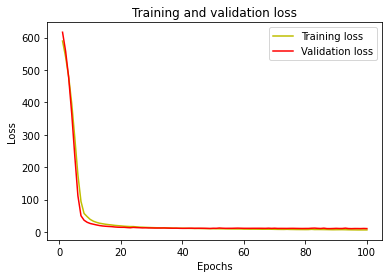

In [111]:

from matplotlib import pyplot as plt 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(loss) + 1) 
plt.plot(epochs, loss, 'y', label='Training loss') 
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend() 
plt.show() 


Nous remarquons que le modèle converge très rapidement, ce qui prouve que je n'ai pas forcement besoin de plusieurs epoch de formation

Et la nous avons notre perte d'entrainement et de validation

Testez les performances du modèle entrainé : 


In [112]:
predictions = model.predict(X_test_scaled[:5]) 
print("Predicted values are:\n ", predictions) 
print("Real values are: \n", y_test[:5]) 

Predicted values are:
  [[18.799522]
 [19.23196 ]
 [20.402485]
 [20.690048]
 [14.47461 ]]
Real values are: 
 498    21.2
94     20.6
150    21.5
221    21.7
423    13.4
Name: PRICE, dtype: float64


Nous avons les valeurs qui ne sont pas très éloigné du prix réel

### Affichez l’erreur quadratique moyenne(mse) et l’erreur moyenne au sens de la valeur absolue (mae) : 

In [113]:
mse_neural, mae_neural = model.evaluate(X_test_scaled, y_test) 
print('Mean squared error from neural net: ', mse_neural) 
print('Mean absolute error from neural net: ', mae_neural) 

4/4 [==============================] - 0s 2ms/step - loss: 14.8582 - mae: 2.8234
Mean squared error from neural net:  14.858160018920898
Mean absolute error from neural net:  2.82342791557312


## Exercice 4 : Comparaison des performances   
Les performances de ce réseau de neurones profonds sont comparées à des algorithmes classiques 
d’apprentissage statistique (régréssion linéaire, arbre de decision, random Forest).

### Régression linéaire 
#### Importez tout d’abord les librairies : 




In [114]:
from sklearn import linear_model 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error 


#### Commentez chacune des lignes du code : 

In [115]:
lr_model = linear_model.LinearRegression()  # definition du model
lr_model.fit(X_train_scaled, y_train)  # entrainement
y_pred_lr = lr_model.predict(X_test_scaled) # prediction

#### Analysez et comparez les performances de ce modèle au réseau de neurones profonds : 

In [116]:
mse_lr = mean_squared_error(y_test, y_pred_lr) 
mae_lr = mean_absolute_error(y_test, y_pred_lr) 
print('Mean squared error from linear regression: ', mse_lr) 
print('Mean absolute error from linear regression: ', mae_lr)

Mean squared error from linear regression:  16.49535197593167
Mean absolute error from linear regression:  3.055894153890957


Nous avons un mse et mae superieur à celle des réseau de neurones, ce qui confirme que les réseaux de neuronnes fonctionne bien que la la regression linéaire

### Arbres de décision 
#### Commentez chacune des lignes du code :


In [117]:
tree = DecisionTreeRegressor()  # definition du modèle
tree.fit(X_train_scaled, y_train) # entrainement
y_pred_tree = tree.predict(X_test_scaled) # prediction du modèle


#### Analysez et comparez les performances de ce modèle au réseau de neurones profonds : 


In [118]:
mse_dt = mean_squared_error(y_test, y_pred_tree) 
mae_dt = mean_absolute_error(y_test, y_pred_tree) 
print('Mean squared error using decision tree: ', mse_dt) 
print('Mean absolute error using decision tree: ', mae_dt) 

Mean squared error using decision tree:  20.487647058823526
Mean absolute error using decision tree:  3.247058823529411


### Random Forest 
#### Commentez chacune des lignes du code :


In [119]:
from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor(n_estimators = 30, random_state=30) # un modèle avec 30 arbres utilisant une regression
model.fit(X_train_scaled, y_train) # entrainement du modèle
y_pred_RF = model.predict(X_test_scaled) # prediction du modèle

#### Analysez et comparez les performances de ce modèle au réseau de neurones profonds : 

In [120]:

mse_RF = mean_squared_error(y_test, y_pred_RF)  # calcul du mse
mae_RF = mean_absolute_error(y_test, y_pred_RF) # calcul du mae
print('Mean squared error using Random Forest: ', mse_RF) 
print('Mean absolute error Using Random Forest: ', mae_RF)

Mean squared error using Random Forest:  12.701104793028327
Mean absolute error Using Random Forest:  2.408235294117647


Nous avons un bon résultat par rapport au modèle précedant, ce qui montre arbres de décision est très bon algo pour plusieurs problèmes de regression et de classification par rapport au reseau de neuronnes et la regression linéaire